In [ ]:
import string
import re
import os
import nltk
import pandas as pd
import numpy as np
import json
import glob
import gzip
import tensorflow as tf
from tensorflow import keras
import time

import matplotlib.pyplot as plt

SEED = 1013
np.random.seed(SEED)

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import pandas as pd 
import numpy as np 
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy import sparse
import os
import pickle
import emoji
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.util import ngrams

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

In [ ]:
covid_files_path = r'/Users/Meghna/Desktop/covid_data/covid_tweets.json'

covid_train_data = []
noncovid_train_data = []
covid_train_labels = []
noncovid_train_labels = []

covid_train_data2 = []
noncovid_train_data2 = []


try:
    with open(covid_files_path,'r') as fin:
        for line in fin:
            tweet = json.loads(line)
            covid_train_data.append(tweet['text'])
            covid_train_labels.append(1)
except:
    print("Faulty file ")

In [ ]:
covid_box_plot = [len(t) for t in covid_train_data]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(covid_box_plot)
plt.show()

In [ ]:
noncovid_files_path = r'/Users/Meghna/Desktop/noncovid_data/*'
noncovid_files = glob.glob(noncovid_files_path)
num_noncovid_tweets = 0

for i in range(len(noncovid_files)):
    print("opening file", noncovid_files[i])
    try:
        with gzip.open(noncovid_files[i],'r') as fin:
            for line in fin:
                if num_noncovid_tweets < 27068:
                    tweet = json.loads(line)
                    noncovid_train_data.append(tweet['text'])
                    noncovid_train_labels.append(0)
                    num_noncovid_tweets += 1

    except:
        print("Faulty file ", noncovid_files[i])

In [ ]:
noncovid_box_plot = [len(t) for t in noncovid_train_data]

In [ ]:
pd.set_option('display.max_colwidth', None)
df1 = pd.DataFrame(columns=['text','label'])
df1['text'] = covid_train_data
df1['label'] = covid_train_labels
df1['pre_clean_len'] = [len(t) for t in df1.text]
df1[df1.pre_clean_len > 200]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(noncovid_box_plot)
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)
df2 = pd.DataFrame(columns=['text','label'])
df2['text'] = noncovid_train_data
df2['label'] = noncovid_train_labels
df2['pre_clean_len'] = [len(t) for t in df2.text]
df2[df2.pre_clean_len > 800]

In [ ]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    stripped = re.sub(r'\@w+','',stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [ ]:
# def process_tweet(tweet):
#     """Process tweet function.
#     Input:
#         tweet: a string containing a tweet
#     Output:
#         tweets_clean: a list of words containing the processed tweet
#     """
#     stemmer = PorterStemmer()
#     stopwords_english = stopwords.words('english')
#     tweet = emoji.demojize(tweet, language='en')
#     #remove mention sign and name
#     tweet = re.sub(r'\@w+','',tweet)
#     # remove stock market tickers like $GE
#     tweet = re.sub(r'\$\w*', '', tweet)
#     # remove old style retweet text "RT"
#     tweet = re.sub(r'^RT[\s]+', '', tweet)
#     # remove hyperlinks
#     tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
#     # remove hashtags
#     # only removing the hash # sign from the word
#     tweet = re.sub(r'#', '', tweet)
#     # tokenize tweets
# #     tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
# #                                reduce_len=True)
# #     tweet_tokens = tokenizer.tokenize(tweet)
#     tweet_tokens = tweet.split()
#     tweets_clean = []
#     for word in tweet_tokens:
#         if (word not in stopwords_english and  # remove stopwords
#                 word not in string.punctuation):  # remove punctuation
#             stem_word = stemmer.stem(word)  # stemming word
#             tweets_clean.append(stem_word)

#     return ''.join(tweets_clean)

In [ ]:
for tweet in covid_train_data:
    covid_train_data2.append(tweet_cleaner_updated(tweet))
    
for ntweet in noncovid_train_data:
    noncovid_train_data2.append(tweet_cleaner_updated(ntweet))

train_data = covid_train_data2 + noncovid_train_data2
train_labels = covid_train_labels + noncovid_train_labels

In [ ]:
covid_box_plot2 = [len(t) for t in covid_train_data2]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(covid_box_plot2)
plt.show()

In [ ]:
noncovid_box_plot2 = [len(t) for t in noncovid_train_data2]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(noncovid_box_plot2)
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)
df3 = pd.DataFrame(columns=['text','label'])
df3['text'] = noncovid_train_data2
df3['label'] = noncovid_train_labels
df3['pre_clean_len'] = [len(t) for t in df3.text]
df3[df3.pre_clean_len > 150].head()

In [ ]:
pd.set_option('display.max_colwidth', None)
df4 = pd.DataFrame(columns=['text','label'])
df4['text'] = covid_train_data2
df4['label'] = covid_train_labels
df4['pre_clean_len'] = [len(t) for t in df4.text]
df4[df4.pre_clean_len > 150].head()

In [ ]:
neg_tweets = df3[df3.label == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
pos_tweets = df4[df4.label == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [ ]:
for t in neg_tweets.text[:200]:
    if 'china' in t:
        print(t)

In [ ]:
for t in pos_tweets.text[:800]:
    if 'china' in t:
        print(t)

In [ ]:
train_data = covid_train_data2 + noncovid_train_data2
train_labels = covid_train_labels + noncovid_train_labels

In [ ]:
my_df = pd.DataFrame(columns=['text','target'])
my_df['text'] = train_data
my_df['target'] = train_labels
my_df.head()

In [ ]:
cvec = CountVectorizer()
cvec.fit(my_df.text)

In [ ]:
len(cvec.get_feature_names())

In [ ]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [ ]:
print(neg_doc_matrix[1])
print(neg[:20])
print(neg_doc_matrix.toarray()[10])
print(term_freq_df.head())

In [ ]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.text)

In [ ]:
document_matrix = cvec.transform(my_df.text)

In [ ]:
neg_doc_matrix2 = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix2 = cvec.transform(my_df[my_df.target == 1].text)
neg_tf2 = np.sum(neg_doc_matrix2,axis=0)
pos_tf2 = np.sum(pos_doc_matrix2,axis=0)
neg2 = np.squeeze(np.asarray(neg_tf2))
pos2 = np.squeeze(np.asarray(pos_tf2))
term_freq_df2 = pd.DataFrame([neg2,pos2],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:30]

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [ ]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

In [ ]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='neg_rate', ascending=False).iloc[:10]

In [ ]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

In [ ]:
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2.sort_values(by='neg_freq_pct', ascending=False).iloc[:10]

In [ ]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
                                                                   if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

In [ ]:
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='neg_hmean', ascending=False).iloc[:10]

In [ ]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]


In [ ]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]


In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_freq_pct", y="pos_freq_pct",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency Rate')
plt.xlabel('Negative Frequency Rate')
plt.title('neg_freq_pct vs pos_freq_pct')

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [ ]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
output_notebook()
from bokeh.resources import INLINE
import bokeh.io


color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

In [ ]:
train_corpus,test_corpus,train_labels,test_labels = train_test_split(train_data,train_labels,stratify=train_labels,test_size=0.25,random_state=1)
train_texts, train_labels, test_texts, test_labels = train_corpus, train_labels, test_corpus, test_labels
x_train, y_train, x_validation, y_validation = train_corpus,train_labels,test_corpus,test_labels

In [ ]:
x_train, y_train, x_validation, y_validation = train_corpus,train_labels,test_corpus,test_labels

In [ ]:
y_train_len0 = 0
y_train_len1 = 1
for label in y_train:
    if label == 1:
        y_train_len1 += 1
    else:
        y_train_len0 += 1
        
y_val_len0 = 0
y_val_len1 = 0
for label in y_validation:
    if label == 1:
        y_val_len1 += 1
    else:
        y_val_len0 += 1
        

In [ ]:
print( "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (y_train_len0 / (len(x_train)*1.))*100,
                                                                            (y_train_len1 / (len(x_train)*1.))*100))
       
                                                                            
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (y_val_len0 / (len(x_validation)))*100,
                                                                            (y_val_len1 / (len(x_validation)))*100))

In [ ]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if y_val_len0 / (len(x_test)*1.) > 0.5:
        null_accuracy =  y_val_len1/ (len(x_test)*1.)
    else:
        null_accuracy = 1. - (y_val_len1 / (len(x_test)*1.))
    #t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    #train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    #print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
cvec = CountVectorizer()
lr = LogisticRegression(max_iter=200)
n_features = np.arange(10000,48001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result

In [ ]:
from sklearn.feature_extraction import text
z = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:3].index))
c = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[4:11].index))
listofsets = [z,c]
a = frozenset.union(*listofsets)
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

In [ ]:
my_stop_words = a

In [ ]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

In [ ]:
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

In [ ]:
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

In [ ]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(stop_words=my_stop_words,ngram_range=(1, 2))

In [ ]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg2 = nfeature_accuracy_checker(stop_words='english', ngram_range=(1, 2))

In [ ]:
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(stop_words=my_stop_words, ngram_range=(1, 3))

In [ ]:
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg2 = nfeature_accuracy_checker(stop_words='english', ngram_range=(1, 3))

In [ ]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tg2 = pd.DataFrame(feature_result_tg2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg2 = pd.DataFrame(feature_result_bg2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug2 = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram without custom sw')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram without custom sw')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram without custom sw')
plt.plot(nfeatures_plot_tg2.nfeatures, nfeatures_plot_tg2.validation_accuracy,label='trigram without sw')
plt.plot(nfeatures_plot_bg2.nfeatures, nfeatures_plot_bg2.validation_accuracy,label='bigram without sw')
plt.plot(nfeatures_plot_ug2.nfeatures, nfeatures_plot_ug2.validation_accuracy, label='unigram without sw')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if y_val_len0 / (len(x_test)*1.) > 0.5:
        null_accuracy =  y_val_len1/ (len(x_test)*1.)
    else:
        null_accuracy = 1. - (y_val_len1 / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['non_covid', 'covid'],
                         columns=['predicted_non_covid','predicted_covid'])
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print (confusion)
    print ("-"*80)
    print ("Classification Report\n")
    print (classification_report(y_test, y_pred, target_names=['negative','positive']))

In [ ]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [ ]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Tfidf)\n")
feature_result_ugt = nfeature_accuracy_checker(stop_words = my_stop_words,vectorizer=tvec)

In [ ]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS (Tfidf)\n")
feature_result_ugt2 = nfeature_accuracy_checker(stop_words = 'english',vectorizer=tvec)

In [ ]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_ugt3 = nfeature_accuracy_checker(vectorizer=tvec)

In [ ]:
%%time
print ("RESULT FOR BIGRAM WITHOUT CUSTOM STOP WORDS (Tfidf)\n")
feature_result_bgt = nfeature_accuracy_checker(stop_words = my_stop_words,vectorizer=tvec,ngram_range=(1, 2))

In [ ]:
%%time
print ("RESULT FOR BIGRAM WITHOUT STOP WORDS (Tfidf)\n")
feature_result_bgt2 = nfeature_accuracy_checker(stop_words = 'english',vectorizer=tvec,ngram_range=(1, 2))

In [ ]:
%%time
print ("RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_bgt3 = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

In [ ]:
%%time
print ("RESULT FOR TRIGRAM WITHOUT CUSTOM  STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(stop_words = my_stop_words,vectorizer=tvec,ngram_range=(1, 3))

In [ ]:
%%time
print ("RESULT FOR TRIGRAM WITHOUT STOP WORDS (Tfidf)\n")
feature_result_tgt2 = nfeature_accuracy_checker(stop_words = 'english',vectorizer=tvec,ngram_range=(1, 3))

In [ ]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt3 = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

In [ ]:
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt2 = pd.DataFrame(feature_result_ugt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt3 = pd.DataFrame(feature_result_ugt3,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='without custom stop words')
plt.plot(nfeatures_plot_ugt2.nfeatures, nfeatures_plot_ugt2.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_ugt3.nfeatures, nfeatures_plot_ugt3.validation_accuracy,label='with stop words')
plt.title(" tfidf Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt2 = pd.DataFrame(feature_result_bgt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt3 = pd.DataFrame(feature_result_bgt3,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy, label='without custom stop words')
plt.plot(nfeatures_plot_bgt2.nfeatures, nfeatures_plot_bgt2.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_bgt3.nfeatures, nfeatures_plot_bgt3.validation_accuracy,label='with stop words')
plt.title(" tfidf Without stop words VS With stop words (Bigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tgt2 = pd.DataFrame(feature_result_tgt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tgt3 = pd.DataFrame(feature_result_tgt3,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy, label='without custom stop words')
plt.plot(nfeatures_plot_tgt2.nfeatures, nfeatures_plot_tgt2.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_tgt3.nfeatures, nfeatures_plot_tgt3.validation_accuracy,label='with stop words')
plt.title(" tfidf Without stop words VS With stop words (Trigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
nfeatures_plot_tgt2 = pd.DataFrame(feature_result_tgt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt2 = pd.DataFrame(feature_result_bgt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt2 = pd.DataFrame(feature_result_ugt2,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt2.nfeatures, nfeatures_plot_tgt2.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg2.nfeatures, nfeatures_plot_tg2.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt2.nfeatures, nfeatures_plot_bgt2.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg2.nfeatures, nfeatures_plot_bg2.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt2.nfeatures, nfeatures_plot_ugt2.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title(" Without using stop words N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("Without using custom stop words N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
feature_result_bg3 = nfeature_accuracy_checker(ngram_range=(1, 2))
feature_result_tg3 = nfeature_accuracy_checker(ngram_range=(1, 3))

In [ ]:
nfeatures_plot_tgt3 = pd.DataFrame(feature_result_tgt3,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt3 = pd.DataFrame(feature_result_bgt3,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt3= pd.DataFrame(feature_result_ugt3,columns=['nfeatures','validation_accuracy'])

nfeatures_plot_tg3 = pd.DataFrame(feature_result_tg3,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg3 = pd.DataFrame(feature_result_bg3,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt3.nfeatures, nfeatures_plot_tgt3.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg3.nfeatures, nfeatures_plot_tg3.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt3.nfeatures, nfeatures_plot_bgt3.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg3.nfeatures, nfeatures_plot_bg3.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt3.nfeatures, nfeatures_plot_ugt3.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("Using stop words N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
def accuracy_summary2(pipeline, x_train, y_train, x_test, y_test):
    if y_val_len0 / (len(x_test)*1.) > 0.5:
        null_accuracy =  y_val_len1/ (len(x_test)*1.)
    else:
        null_accuracy = 1. - (y_val_len1 / (len(x_test)*1.))
    #t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    #train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    #print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, sentiment_fit

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(stop_words = my_stop_words,max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy, model = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf2 = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words = 'english',max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy, model = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation)

In [ ]:
path = r'/Users/Meghna/Desktop/acl2014using/race/'

In [ ]:
test_data = []
test_labels = []
test_data_raw = []

In [ ]:
for file in os.listdir(path):
    file_path= os.path.join(path, file)
    with open(file_path,'r') as f:
        lines = f.readlines()
        for line in lines:
            dict_line = json.loads(line)
            test_data_raw.append(dict_line['description'])
            test_labels.append(0)
for data in test_data_raw:
    test_data.append(data)

In [ ]:
testing_covid_box_plot = [len(t) for t in test_data]
pd.set_option('display.max_colwidth', None)
test_df = pd.DataFrame(columns=['text','label'])
test_df['text'] = test_data
test_df['label'] = test_labels
test_df['pre_clean_len'] = [len(t) for t in test_df.text]
test_df[test_df.pre_clean_len > 150]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(testing_covid_box_plot)
plt.show()

In [ ]:
test_data = []
test_labels = []
test_data_raw = []

for file in os.listdir(path):
    file_path= os.path.join(path, file)
    with open(file_path,'r') as f:
        lines = f.readlines()
        for line in lines:
            dict_line = json.loads(line)
            test_data_raw.append(dict_line['description'])
            test_labels.append(0)
for data in test_data_raw:
    test_data.append(tweet_cleaner_updated(data))
    
    
testing_covid_box_plot = [len(t) for t in test_data]
pd.set_option('display.max_colwidth', None)
test_df = pd.DataFrame(columns=['text','label'])
test_df['text'] = test_data
test_df['label'] = test_labels
test_df['pre_clean_len'] = [len(t) for t in test_df.text]

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(testing_covid_box_plot)
plt.show()

In [ ]:
import collections
df=pd.read_csv('/Users/Meghna/Desktop/Mental_Model_Generation.csv')
responses=df.iloc[2:,12:]

reordered_responses=responses[['Q34','Q58','Q12','Q13','Q14','Q16','Q35','Q18','Q19','Q20','Q21','Q30','Q34','Q17','Q15','Q1','Q39','Q28','Q3','Q4','Q5','Q6','Q9','Q29_1','Q29_2','Q29_3','Q29_4','Q29_5','Q29_6','Q29_7']]

free_form_responses=reordered_responses.iloc[:,:12]

single_choice_responses=reordered_responses.iloc[:,12:]

individual_responses=collections.defaultdict(list)
free_form_responses_without_race=free_form_responses.iloc[:,1:]
race=free_form_responses.iloc[:,0].tolist()
r=-1
for index, row in free_form_responses_without_race.iterrows():
    r+=1
    for i in range(len(row)):
        try:
            if float(row[i])==row[i]:
                #print(row[i])
                continue
        except ValueError:
            individual_responses[(index,race[r])].extend(row)

In [131]:
survey_data = []
survey_labels = []
for i in individual_responses:
    #print(i[0])
    for z in individual_responses[i]:
        if type(z) != float:
            test_data.append(tweet_cleaner_updated(z))
            survey_data.append(tweet_cleaner_updated(z))
            test_labels.append(1)
            survey_labels.append(1)

In [ ]:
test_corpus, test_labels = test_data, test_labels
print(len(test_labels))

In [ ]:
x_train, y_train = train_corpus,train_labels

In [ ]:
vectorizer = 'tfidf'   # set 'count' or 'tfidf'
analyzer = 'word'  # set 'word' or 'both' ( word and char)

In [ ]:
if vectorizer == 'count':
    if analyzer == 'word':
        vectorizer = CountVectorizer(stop_words = my_stop_words,ngram_range=(1, 2),max_features=40000)
    else:
        vectorizer = CountVectorizer(analyzer='word',ngram_range=(1,3))
        char_vectorizer = CountVectorizer(analyzer='char',ngram_range=(2,5))
else:
    if analyzer == 'word':
        vectorizer = TfidfVectorizer(stop_words = 'english',ngram_range=(1, 2),max_features=40000)
    else:
        vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,3))
        char_vectorizer = TfidfVectorizer(analyzer='char',ngram_range=(2,5))

In [ ]:
def get_training_data_and_labels(train_corpus, train_labels):    
    if analyzer == 'word':
        ngram_vectorized_data = vectorizer.fit_transform(train_corpus)
        
        return ngram_vectorized_data, train_labels
    else:
        ngram_vectorized_data = vectorizer.fit_transform(train_corpus)
        char_vectorized_data = char_vectorizer.fit_transform(train_corpus)
        l = np.hstack((ngram_vectorized_data.toarray(), char_vectorized_data.toarray()))
        train_vectorized_data = sparse.csr_matrix(l)
        
        return train_vectorized_data, train_labels 

In [ ]:
def get_test_data_and_labels(test_corpus, test_labels):   
    if analyzer == 'word':
        test_ngram_vectorized_data = vectorizer.transform(test_corpus)
        
        return test_ngram_vectorized_data, test_labels
    else:
        test_ngram_vectorized_data = vectorizer.transform(test_corpus)
        test_char_vectorized_data = char_vectorizer.transform(test_corpus)
        l2 = np.hstack((test_ngram_vectorized_data.toarray(), test_char_vectorized_data.toarray()))
        test_vectorized_data = sparse.csr_matrix(l2)
        
        return test_vectorized_data,test_labels

In [113]:
#X_train, y_train =  get_training_data_and_labels(train_corpus, train_labels)
#X_test, y_test = get_test_data_and_labels(test_corpus, test_labels)
y_test = test_labels
x_test = test_data

In [119]:
def accuracy_summary2(pipeline, x_train, y_train, x_val,y_val,x_test, y_test):
    if y_val_len0 / (len(x_test)*1.) > 0.5:
        null_accuracy =  y_val_len1/ (len(x_test)*1.)
    else:
        null_accuracy = 1. - (y_val_len1 / (len(x_test)*1.))
    #t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    #print(classification_report(y_true, y_pred))
    y_pred = sentiment_fit.predict(x_val)
    #train_test_time = time() - t0
    accuracy = accuracy_score(y_val, y_pred)
    
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    #print ("train and test time: {0:.2f}s".format(train_test_time))
    
    y_true, y_pred_test = y_test, sentiment_fit.predict(x_test)
    print(classification_report(y_true, y_pred_test))
    print ("-"*80)
    return accuracy

In [120]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf2 = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words = 'english',max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation, x_test, y_test)
    model.score

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 292.06%
accuracy score: 95.96%
model is 196.10% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.12      0.02      0.03       770
           1       0.66      0.93      0.77      1547

    accuracy                           0.63      2317
   macro avg       0.39      0.48      0.40      2317
weighted avg       0.48      0.63      0.52      2317

--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 292.06%
accuracy score: 95.92%
model is 196.14% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.23      0.06      0.09       770
           1       0.66      0.90      0.76      1547

    accuracy                           0.62      2317
   macro avg       0.44      0.48      0.43      2317
weighted avg       0

In [123]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(stop_words = my_stop_words,max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation, x_test, y_test)

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 292.06%
accuracy score: 96.24%
model is 195.82% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.06      0.02      0.02       770
           1       0.64      0.87      0.74      1547

    accuracy                           0.58      2317
   macro avg       0.35      0.44      0.38      2317
weighted avg       0.44      0.58      0.50      2317

--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 292.06%
accuracy score: 95.20%
model is 196.86% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.13      0.05      0.07       770
           1       0.64      0.83      0.72      1547

    accuracy                           0.57      2317
   macro avg       0.38      0.44      0.40      2317
weighted avg       0

In [124]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

# clf1 = LogisticRegression()
# clf2 = LinearSVC()
# clf3 = MultinomialNB()
# clf4 = RidgeClassifier()
# clf5 = PassiveAggressiveClassifier()

eclf3 = MultinomialNB()

for clf, label in zip([eclf3], ['Multinomial NB']):
    checker_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(stop_words = my_stop_words,max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation, x_test, y_test)

Validation result for Multinomial NB
MultinomialNB()
null accuracy: 292.06%
accuracy score: 90.07%
model is 201.99% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.92      0.40      0.55       770
           1       0.77      0.98      0.86      1547

    accuracy                           0.79      2317
   macro avg       0.85      0.69      0.71      2317
weighted avg       0.82      0.79      0.76      2317

--------------------------------------------------------------------------------


In [142]:
eclf4 = MultinomialNB()

for clf, label in zip([eclf4], ['Multinomial NB']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words = 'english',max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation, x_test, y_test)

Validation result for Multinomial NB
MultinomialNB()
null accuracy: 175.13%
accuracy score: 89.72%
model is 85.41% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.81      0.42      0.55       770
           1       0.87      0.98      0.92      3094

    accuracy                           0.87      3864
   macro avg       0.84      0.70      0.74      3864
weighted avg       0.86      0.87      0.85      3864

--------------------------------------------------------------------------------


In [150]:
noncovid_files_path2 = r'/Users/Meghna/Desktop/noncovid_tweets_aug.gz'
noncovid_data2 = []
noncovid_labels2 = []

with gzip.open(noncovid_files_path2,'r') as fin:
    for line in fin:
        tweet = json.loads(line)
        noncovid_data2.append(tweet_cleaner_updated(tweet['text']))
        noncovid_labels2.append(0)

In [151]:
x_test2 = survey_data + noncovid_data2
y_test2 = survey_labels + noncovid_labels2

In [152]:
eclf5 = MultinomialNB()

for clf, label in zip([eclf5], ['Multinomial NB']):
    checker_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(stop_words = my_stop_words,max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation, x_test2, y_test2)

Validation result for Multinomial NB
MultinomialNB()
null accuracy: 191.65%
accuracy score: 90.07%
model is 101.58% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1984
           1       0.86      0.98      0.92      1547

    accuracy                           0.93      3531
   macro avg       0.93      0.93      0.93      3531
weighted avg       0.93      0.93      0.93      3531

--------------------------------------------------------------------------------


In [153]:
eclf6 = MultinomialNB()

for clf, label in zip([eclf6], ['Multinomial NB']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words = 'english',max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation, x_test2, y_test2)

Validation result for Multinomial NB
MultinomialNB()
null accuracy: 191.65%
accuracy score: 89.72%
model is 101.92% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1984
           1       0.87      0.98      0.92      1547

    accuracy                           0.93      3531
   macro avg       0.92      0.93      0.92      3531
weighted avg       0.93      0.93      0.93      3531

--------------------------------------------------------------------------------


In [154]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf7 = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf7], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(stop_words = my_stop_words,max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation, x_test2, y_test2)

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 191.65%
accuracy score: 96.24%
model is 95.41% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1984
           1       0.90      0.87      0.88      1547

    accuracy                           0.90      3531
   macro avg       0.90      0.90      0.90      3531
weighted avg       0.90      0.90      0.90      3531

--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 191.65%
accuracy score: 95.20%
model is 96.45% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1984
           1       0.89      0.83      0.86      1547

    accuracy                           0.88      3531
   macro avg       0.89      0.88      0.88      3531
weighted avg       0.8

In [155]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf8 = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words = 'english',max_features=40000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation, x_test2, y_test2)

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 191.65%
accuracy score: 95.96%
model is 95.69% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1984
           1       0.89      0.93      0.91      1547

    accuracy                           0.92      3531
   macro avg       0.92      0.92      0.92      3531
weighted avg       0.92      0.92      0.92      3531

--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 191.65%
accuracy score: 95.92%
model is 95.72% less accurate than null accuracy
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1984
           1       0.90      0.90      0.90      1547

    accuracy                           0.91      3531
   macro avg       0.91      0.91      0.91      3531
weighted avg       0.9

In [178]:
#x_train_df = pd.DataFrame(columns =['train_text', 'train_label'])
x_train_df = pd.DataFrame(columns =['train_text'])
x_train_df['train_text'] = x_train
#x_train_df['train_label'] = y_train
x_val_df = pd.DataFrame(columns =['val_text'])
x_val_df['val_text'] = x_validation
#x_val_df['val_label'] = y_validation
x_test_df = pd.DataFrame(columns =['test_text'])
x_test_df['test_text'] = x_test
#x_test_df['test_label'] = y_test
x_test2_df = pd.DataFrame(columns =['test2_text'])
x_test2_df['test2_text'] = x_test2
#x_test2_df['test2_label'] = y_test2

In [210]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

x_train1 = pd.Series(x_train)
x_val1 = pd.Series(x_validation)
x_test_s1 = pd.Series(x_test)
x_test_s2 = pd.Series(x_test2)
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result
all_x = pd.concat([x_train1,x_val1,x_test_s1, x_test_s2])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [211]:
len(all_x_w2v)

61531

In [311]:
model_ug_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=2, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

100%|██████████| 61531/61531 [00:00<00:00, 2258784.83it/s]


In [312]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|██████████| 61531/61531 [00:00<00:00, 4022376.82it/s]


CPU times: user 1min 26s, sys: 6.65 s, total: 1min 33s
Wall time: 53 s


In [244]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.dv[prefix]
        n += 1
    return vecs

In [246]:
train_vecs_dbow = get_vectors(model_ug_dbow, x_train1, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_val1, 100)

In [247]:
clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [248]:
clf.score(validation_vecs_dbow, y_validation)

0.7123540712280183

In [219]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

100%|██████████| 61531/61531 [00:00<00:00, 3734386.54it/s]


In [220]:
%%time
for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

100%|██████████| 61531/61531 [00:00<00:00, 3874489.11it/s]


CPU times: user 2min 10s, sys: 7.58 s, total: 2min 18s
Wall time: 59 s


In [222]:
train_vecs_dmc = get_vectors(model_ug_dmc, x_train1, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, x_val1, 100)

In [223]:
clf = LogisticRegression()
clf.fit(train_vecs_dmc, y_train)

LogisticRegression()

In [224]:
clf.score(validation_vecs_dmc, y_validation)

0.6674301758534062

In [227]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

100%|██████████| 61531/61531 [00:00<00:00, 3830155.67it/s]


In [228]:
%%time
for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha

100%|██████████| 61531/61531 [00:00<00:00, 3931684.76it/s]


CPU times: user 2min 22s, sys: 21.4 s, total: 2min 44s
Wall time: 1min 41s


In [231]:
train_vecs_dmm = get_vectors(model_ug_dmm, x_train1, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_val1, 100)

In [232]:
clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)

LogisticRegression()

In [233]:
clf.score(validation_vecs_dmm, y_validation)

0.686641052164918

In [234]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [235]:
train_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_train1, 200)
validation_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_val1, 200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [236]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmc, y_train)

CPU times: user 1.14 s, sys: 115 ms, total: 1.26 s
Wall time: 376 ms


LogisticRegression()

In [237]:
clf.score(validation_vecs_dbow_dmc, y_validation)

0.7003103295404167

In [239]:
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train1, 200)
validation_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_val1, 200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [240]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm, y_train)

CPU times: user 1.2 s, sys: 307 ms, total: 1.51 s
Wall time: 541 ms


LogisticRegression()

In [241]:
clf.score(validation_vecs_dbow_dmm, y_validation)

0.7017142012708734

In [255]:
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

In [256]:
tokenized_train = [t.split() for t in x_train]

In [257]:
%%time
phrases = Phrases(tokenized_train)
bigram = Phraser(phrases)

CPU times: user 1.74 s, sys: 52.6 ms, total: 1.79 s
Wall time: 1.79 s


In [260]:
def labelize_tweets_bg(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(bigram[t.split()], [prefix + '_%s' % i]))
    return result

In [261]:
all_x_w2v_bg = labelize_tweets_bg(all_x, 'all')

In [262]:
cores = multiprocessing.cpu_count()
model_bg_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dbow.build_vocab([x for x in tqdm(all_x_w2v_bg)])

100%|██████████| 61531/61531 [00:00<00:00, 3602905.44it/s]


In [263]:
%%time
for epoch in range(30):
    model_bg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dbow.alpha -= 0.002
    model_bg_dbow.min_alpha = model_bg_dbow.alpha

100%|██████████| 61531/61531 [00:00<00:00, 3931145.76it/s]


CPU times: user 1min 28s, sys: 7.19 s, total: 1min 35s
Wall time: 55.5 s


In [264]:
train_vecs_dbow_bg = get_vectors(model_bg_dbow, x_train1, 100)
validation_vecs_dbow_bg = get_vectors(model_bg_dbow, x_val1, 100)

In [265]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_bg, y_train)

CPU times: user 407 ms, sys: 57.5 ms, total: 464 ms
Wall time: 157 ms


LogisticRegression()

In [266]:
clf.score(validation_vecs_dbow_bg, y_validation)

0.6912959952711689

In [267]:
cores = multiprocessing.cpu_count()
model_bg_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmc.build_vocab([x for x in tqdm(all_x_w2v_bg)])

100%|██████████| 61531/61531 [00:00<00:00, 3852741.16it/s]


In [268]:
%%time
for epoch in range(30):
    model_bg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmc.alpha -= 0.002
    model_bg_dmc.min_alpha = model_bg_dmc.alpha

100%|██████████| 61531/61531 [00:00<00:00, 3867985.36it/s]


CPU times: user 2min 10s, sys: 7.49 s, total: 2min 18s
Wall time: 59 s


In [269]:
train_vecs_dmc_bg = get_vectors(model_bg_dmc, x_train1, 100)
validation_vecs_dmc_bg = get_vectors(model_bg_dmc, x_val1, 100)

In [270]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dmc_bg, y_train)

CPU times: user 278 ms, sys: 73.2 ms, total: 352 ms
Wall time: 120 ms


LogisticRegression()

In [271]:
clf.score(validation_vecs_dmc_bg, y_validation)

0.6696468154278115

In [272]:
cores = multiprocessing.cpu_count()
model_bg_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmm.build_vocab([x for x in tqdm(all_x_w2v_bg)])

100%|██████████| 61531/61531 [00:00<00:00, 3891900.70it/s]


In [274]:
%%time
for epoch in range(30):
    model_bg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmm.alpha -= 0.002
    model_bg_dmm.min_alpha = model_bg_dmm.alpha

100%|██████████| 61531/61531 [00:00<00:00, 3821534.94it/s]


CPU times: user 2min 21s, sys: 21.6 s, total: 2min 42s
Wall time: 1min 41s


In [275]:
train_vecs_dmm_bg = get_vectors(model_bg_dmm, x_train1, 100)
validation_vecs_dmm_bg = get_vectors(model_bg_dmm, x_val1, 100)

In [276]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dmm_bg, y_train)

CPU times: user 381 ms, sys: 41.7 ms, total: 422 ms
Wall time: 127 ms


LogisticRegression()

In [277]:
clf.score(validation_vecs_dmm_bg, y_validation)

0.6892271316683907

In [278]:
train_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_train1, 200)
validation_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_val1, 200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [279]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmc_bg, y_train)

CPU times: user 1.26 s, sys: 77.2 ms, total: 1.34 s
Wall time: 377 ms


LogisticRegression()

In [280]:
clf.score(validation_vecs_dbow_dmc_bg, y_validation)

0.697133146150436

In [283]:
train_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_train1, 200)
validation_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_val1, 200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [284]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm_bg, y_train)

CPU times: user 1.29 s, sys: 176 ms, total: 1.46 s
Wall time: 456 ms


LogisticRegression()

In [285]:
clf.score(validation_vecs_dbow_dmm_bg, y_validation)

0.6979459139943845

In [286]:
%%time
tg_phrases = Phrases(bigram[tokenized_train])
trigram = Phraser(tg_phrases)

CPU times: user 2.57 s, sys: 105 ms, total: 2.67 s
Wall time: 2.71 s


In [287]:
def labelize_tweets_tg(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(trigram[bigram[t.split()]], [prefix + '_%s' % i]))
    return result

In [288]:
all_x_w2v_tg = labelize_tweets_tg(all_x, 'all')

In [289]:
model_tg_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dbow.build_vocab([x for x in tqdm(all_x_w2v_tg)])


100%|██████████| 61531/61531 [00:00<00:00, 3731201.13it/s]


In [290]:


%%time
for epoch in range(30):
    model_tg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dbow.alpha -= 0.002
    model_tg_dbow.min_alpha = model_tg_dbow.alpha



100%|██████████| 61531/61531 [00:00<00:00, 3920873.26it/s]


CPU times: user 1min 26s, sys: 7.04 s, total: 1min 33s
Wall time: 53.5 s


In [291]:


train_vecs_dbow_tg = get_vectors(model_tg_dbow, x_train1, 100)
validation_vecs_dbow_tg = get_vectors(model_tg_dbow, x_val1, 100)


In [292]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_tg, y_train)

CPU times: user 361 ms, sys: 139 ms, total: 500 ms
Wall time: 180 ms


LogisticRegression()

In [293]:
clf.score(validation_vecs_dbow_tg, y_validation)

0.6976503620511305

In [294]:
cores = multiprocessing.cpu_count()
model_tg_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmc.build_vocab([x for x in tqdm(all_x_w2v_tg)])

100%|██████████| 61531/61531 [00:00<00:00, 3855388.70it/s]


In [295]:
%%time
for epoch in range(30):
    model_tg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmc.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

100%|██████████| 61531/61531 [00:00<00:00, 4021060.72it/s]


CPU times: user 2min 10s, sys: 7.51 s, total: 2min 17s
Wall time: 59.1 s


In [296]:
train_vecs_dmc_tg = get_vectors(model_tg_dmc, x_train1, 100)
validation_vecs_dmc_tg = get_vectors(model_tg_dmc, x_val1, 100)

In [297]:

%%time
clf = LogisticRegression()
clf.fit(train_vecs_dmc_tg, y_train)


CPU times: user 350 ms, sys: 62.5 ms, total: 413 ms
Wall time: 147 ms


LogisticRegression()

In [298]:
clf.score(validation_vecs_dmc_tg, y_validation)

0.6676518398108467

In [299]:
cores = multiprocessing.cpu_count()
model_tg_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmm.build_vocab([x for x in tqdm(all_x_w2v_tg)])

100%|██████████| 61531/61531 [00:00<00:00, 3955426.60it/s]


In [300]:
%%time
for epoch in range(30):
    model_tg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmm.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha


100%|██████████| 61531/61531 [00:00<00:00, 4002539.11it/s]


CPU times: user 2min 20s, sys: 21.9 s, total: 2min 42s
Wall time: 1min 41s


In [301]:
train_vecs_dmm_tg = get_vectors(model_tg_dmm, x_train1, 100)
validation_vecs_dmm_tg = get_vectors(model_tg_dmm, x_val1, 100)

In [302]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dmm_tg, y_train)

CPU times: user 374 ms, sys: 50.2 ms, total: 424 ms
Wall time: 133 ms


LogisticRegression()

In [303]:
clf.score(validation_vecs_dmm_tg, y_validation)

0.6898921235407123

In [304]:
train_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_train1, 200)
validation_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_val1, 200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [305]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmc_tg, y_train)

CPU times: user 1.16 s, sys: 92.7 ms, total: 1.26 s
Wall time: 415 ms


LogisticRegression()

In [306]:
clf.score(validation_vecs_dbow_dmc_tg, y_validation)

0.7039308408452786

In [307]:
train_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_train1, 200)
validation_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_val1, 200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [308]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm_tg, y_train)

CPU times: user 1.78 s, sys: 138 ms, total: 1.91 s
Wall time: 554 ms


LogisticRegression()

In [309]:
clf.score(validation_vecs_dbow_dmm_tg, y_validation)

0.7002364415546032

In [313]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train1, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_val1, 200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [314]:


%%time
clf = LogisticRegression()
clf.fit(train_vecs_ugdbow_tgdmm, y_train)



CPU times: user 1.28 s, sys: 391 ms, total: 1.68 s
Wall time: 595 ms


LogisticRegression()

In [315]:
clf.score(validation_vecs_ugdbow_tgdmm, y_validation)

0.6996453376680951

Text(0.5, 0, '$\\chi^2$')

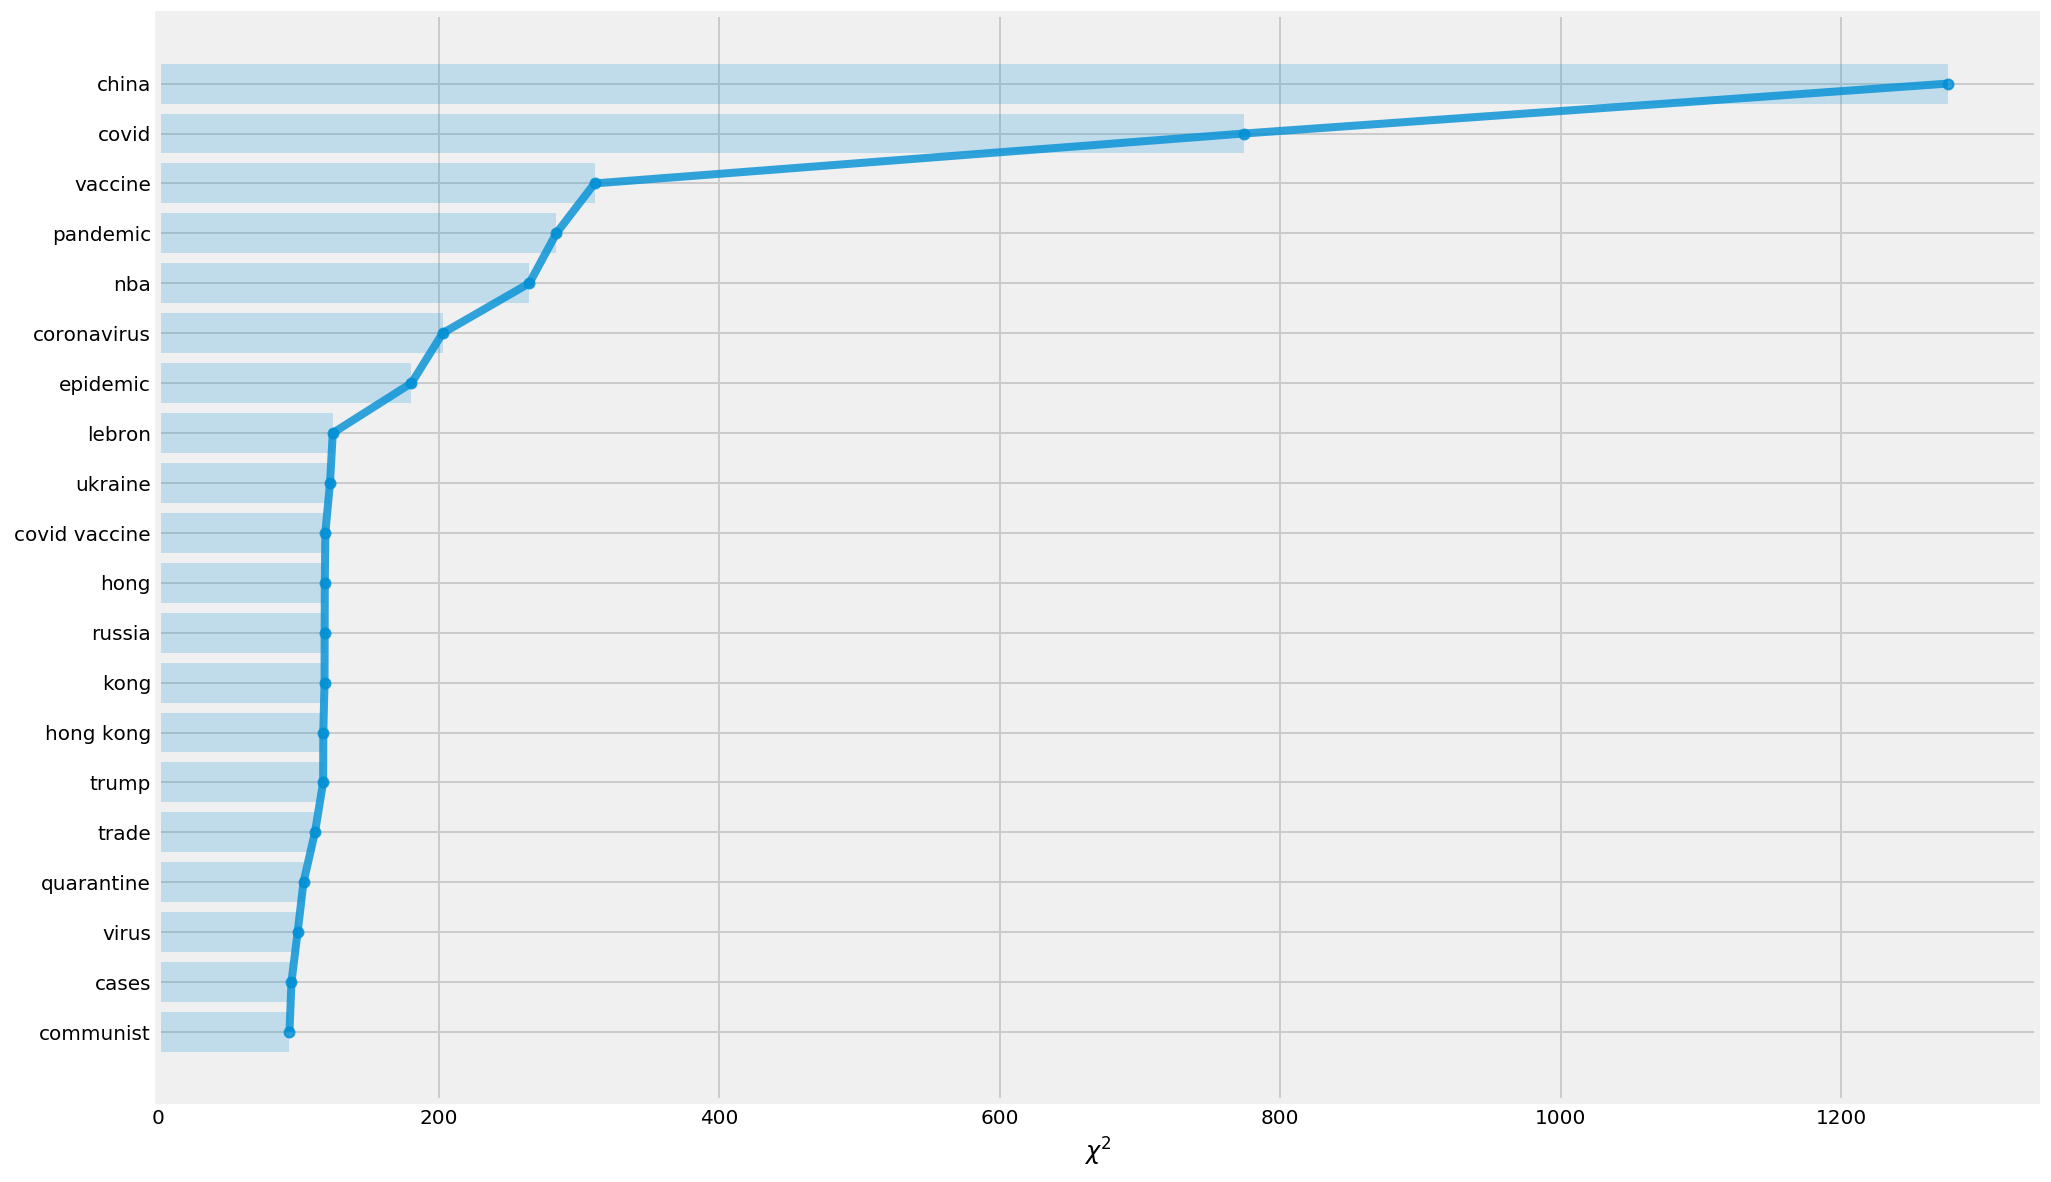

In [397]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
pp =[]
qq =[]
tvec = TfidfVectorizer(stop_words = 'english',max_features=40000,ngram_range=(1, 2))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)
chi2score = chi2(x_train_tfidf, y_train)[0]

plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
#print(wchi2[-20:])
topchi2 = zip(*wchi2[-20:])
#print(list(*topchi2))
for (p,q) in wchi2[-20:]:
    pp.append(p)
    qq.append(q)
x = range(len(qq))
labels = pp
plt.barh(x,qq, align='center', alpha=0.2)
plt.plot(qq, x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

Text(0.5, 0, '$\\chi^2$')

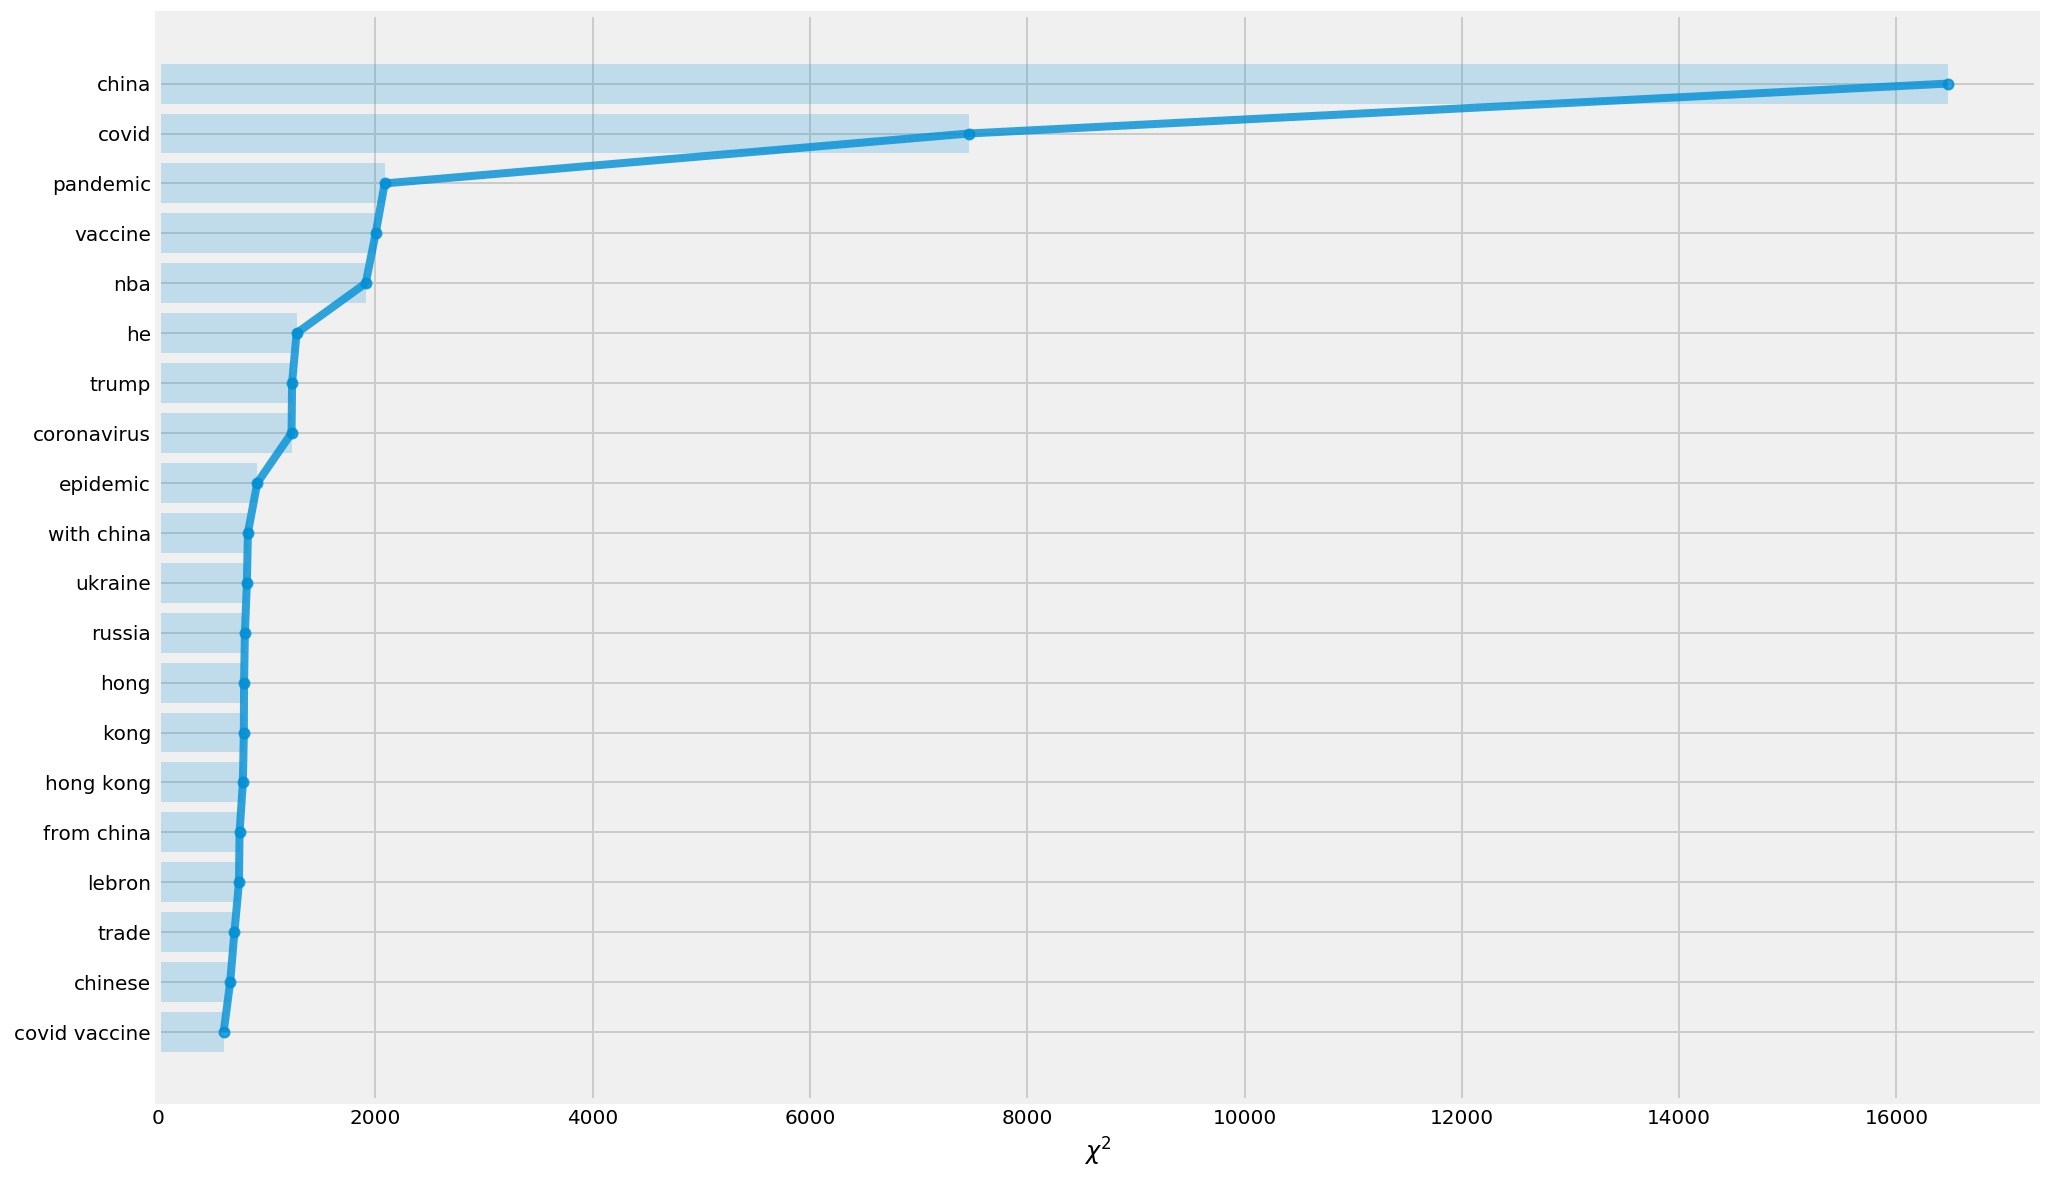

In [383]:
from sklearn.feature_selection import chi2

pp =[]
qq =[]
tvec = CountVectorizer(stop_words = my_stop_words,max_features=48000,ngram_range=(1, 2))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)
chi2score = chi2(x_train_tfidf, y_train)[0]

plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
#print(wchi2[-20:])
topchi2 = zip(*wchi2[-20:])
#print(list(*topchi2))
for (p,q) in wchi2[-20:]:
    pp.append(p)
    qq.append(q)
x = range(len(qq))
labels = pp
plt.barh(x,qq, align='center', alpha=0.2)
plt.plot(qq, x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [398]:
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
for n in np.arange(10000,48000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    #clf = LogisticRegression(max_iter = 200)
    clf = MultinomialNB()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print ("chi2 feature selection evaluation calculated for {} features".format(n))

chi2 feature selection evaluation calculated for 10000 features
chi2 feature selection evaluation calculated for 20000 features
chi2 feature selection evaluation calculated for 30000 features
chi2 feature selection evaluation calculated for 40000 features


In [399]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
#cvec = CountVectorizer()
cvec = TfidfVectorizer()
#lr = LogisticRegression(max_iter=200)
lr = MultinomialNB()
n_features = np.arange(10000,48001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result

In [400]:
feature_result_bgtmn = nfeature_accuracy_checker(stop_words = 'english',ngram_range=(1, 2))
nfeatures_plot_bgtmn = pd.DataFrame(feature_result_bgtmn,columns=['nfeatures','validation_accuracy'])

MultinomialNB()


Validation result for 10000 features
null accuracy: 50.00%
accuracy score: 88.83%
model is 38.83% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.00%
accuracy score: 89.35%
model is 39.35% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.00%
accuracy score: 89.59%
model is 39.59% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.00%
accuracy score: 89.72%
model is 39.72% more accurate than null accuracy
--------------------------------------------------------------------------------


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


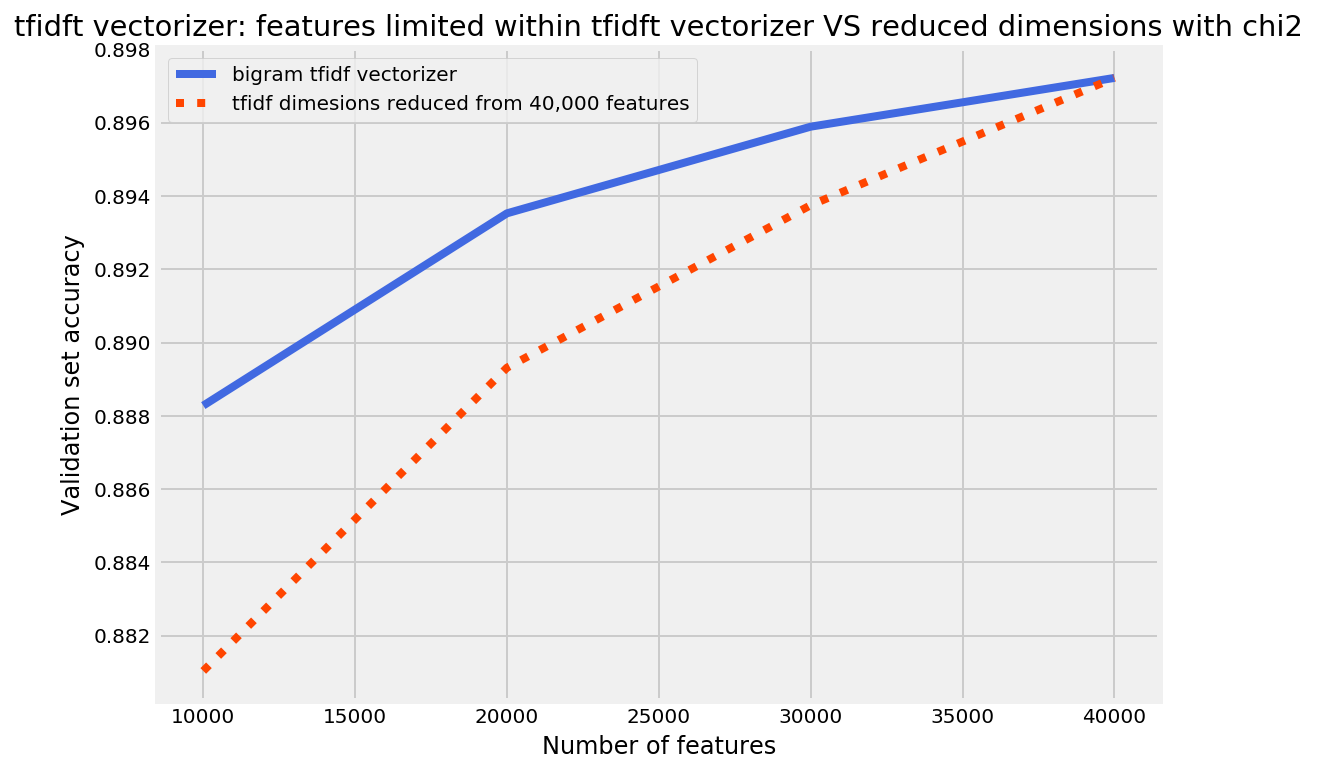

In [401]:
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_bgtmn.nfeatures, nfeatures_plot_bgtmn.validation_accuracy,label='bigram tfidf vectorizer',color='royalblue')
plt.plot(np.arange(10000,48000,10000), ch2_result,label='tfidf dimesions reduced from 40,000 features',linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [390]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
d2v_ugdbow_tgdmm_std = scaler.fit_transform(x_train)
d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(x_validation)

# d2v_ugdbow_tgdmm_std = scaler.fit_transform(train_vecs_ugdbow_tgdmm)
# d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(validation_vecs_ugdbow_tgdmm)


In [391]:
from sklearn.decomposition import PCA

d2v_pca = PCA().fit()

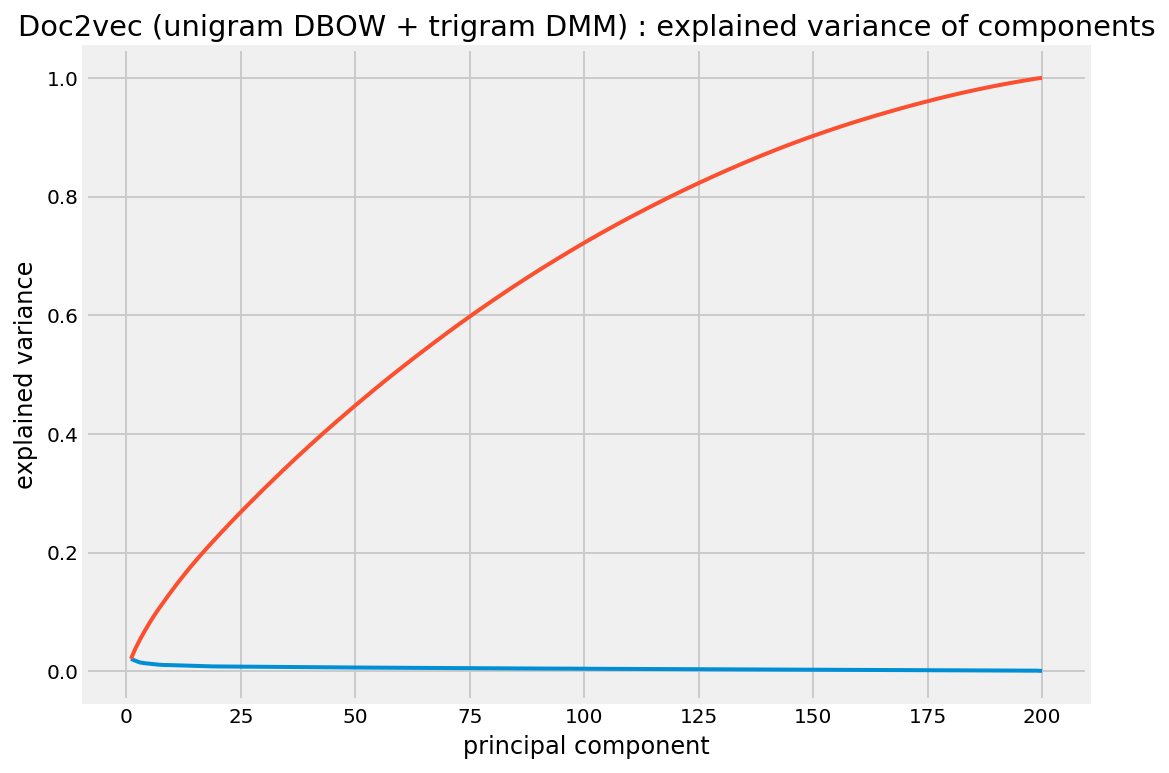

In [392]:
fig, ax = plt.subplots(figsize=(8,6))

x_values = range(1, d2v_pca.n_components_+1)

ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()